# Apply PCM to 3D gridded products

Apply PCM method to __3D gridded products__ defined as inputs in BlueCloud project:
- GLOBAL-ANALYSIS-FORECAST-PHY-001-024
- GLOBAL_REANALYSIS_PHY_001_030
- GLOBAL_REANALYSIS_PHY_001_031
- GLOBAL_REANALYSIS_BIO_001_029

Only data in Mediterranean sea is used. NetCDF files have been downloaded from CMEMS catalogue.
Notebook developped in __local__

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [ ]:
# try CORA dataset
# file_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/CORA/CORA5.1/field/2016/*_TEMP.nc'
# lon_extent = [120,165]
# lat_extent = [22,55]
# temp_var = 'TEMP'
# ds = xr.open_mfdataset(file_path,combine='by_coords', concat_dim=time_dim)
# ds

In [ ]:
# ds = ds.sel(latitude=slice(lat_extent[0],lat_extent[1]), longitude=slice(lon_extent[0], lon_extent[1])) 
# ds

In [ ]:
#file_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/SODA/assim/SODA_2.2.4/SODA_2.2.4_200801.cdf'
#lon_dim = 'lon'
#lat_dim = 'lat'
#z_dim = 'depth'
#temp_var = 'temp'

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1600874641188_caribe.nc'
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601630960671_safrica.nc'
# mediterranean
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'


# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
lat_dim = 'latitude'
z_dim = 'depth'
temp_var = 'thetao'

#temp_var = 'fe'

__Model options__

In [3]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

#classes
K=10

#fit
features_in_ds = {'temperature': temp_var}

__Plot options__

## Get data
***

Open data files

In [ ]:
#open data file
ds = xr.open_dataset(file_path)
ds

Depth values should be negative

In [ ]:
#at = ds['depth'].attrs
#ds.assign_coords(depth=-np.abs(ds['depth'].values), keep_attrs=True)
ds['depth'] = -np.abs(ds['depth'].values)
#ds['depth'].attrs.update(at) # not working

In [ ]:
# for SODA dataset
#ds['lon'] = np.mod((ds['lon'].values +180),360) - 180
#ds = ds.sortby('lon')

In [ ]:
#ds['thetao'].isel(depth=5).plot();
ds[temp_var].isel(time=0, depth=5).plot();
#ds[temp_var].isel(depth=0).plot();
#ds['o2'].isel(time=11, depth=5).plot();
#ds['fe'].isel(time=11, depth=5).plot();

## Applying PCM
***

### Create PCM

In [ ]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

m = pcm(K=K, features=pcm_features)
m

### Fit Model

In [ ]:
features_in_ds = {'temperature': temp_var}
#features_in_ds = {'iron': temp_var}
features_zdim=z_dim
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<font color=red>__TODO__</font> : save all trained PCM in a folder

In [ ]:
# save model to development
# m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

### Predict labels

In [ ]:
features_zdim=z_dim
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [ ]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [ ]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.25, 0.5, 0.75, 0.95], of=temp_var, outname=temp_var + '_Q', keep_attrs=True, inplace=True)
#ds

Robustness

In [ ]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

In [ ]:
# save data for development
#ds.to_netcdf('models/tests_ds_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

In [ ]:
ds

## Visualisation
***

In [4]:
# for development
m = pyxpcm.load_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')
ds = xr.open_dataset('models/tests_ds_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

In [5]:
P = Plotter(ds, m)
#P = Plotter(ds, m, coords_dict={'longitude':'lon', 'latitude':'lat'})

#### 1. Vertical structure of classes

In [ ]:
#P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 12), sharey=True, xlabel)
P.vertical_structure(q_variable = temp_var + '_Q', sharey=True, xlabel='Temperature (°C)')
#P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 8), sharey=True, ylim=np.array([-2000,0]))
P.save_BlueCloud('figures/vertical_struc_EX.png')
#P.save_BlueCloud('figures/test.png')

In [ ]:
P.vertical_structure_comp(q_variable = temp_var + '_Q', plot_q= 'all', xlabel='Temperature (°C)')
#P.save_BlueCloud('figures/vertical_struc_comp_EX.png')
P.save_BlueCloud('figures/test1.png')

#### 2. Spatial distribution of classes

In [ ]:
# TODO: when using isel hours are not good
# Input should have only one time step
P.spatial_distribution(time_slice=1)
P.save_BlueCloud('figures/spatial_distr_EX.png')

In [ ]:
P.spatial_distribution(time_slice='most_freq_label')
P.save_BlueCloud('figures/spatial_distr_freq_EX.png')

In [ ]:
# mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=features_zdim)
# mask.plot()

#### 3. Posteriors

In [ ]:
# Input should have only one time step
P.plot_posteriors()
P.save_BlueCloud('figures/posteriors_EX.png')

#### 4. Classes pie chart

498684
Figure saved in figures/pie_chart_EX.png


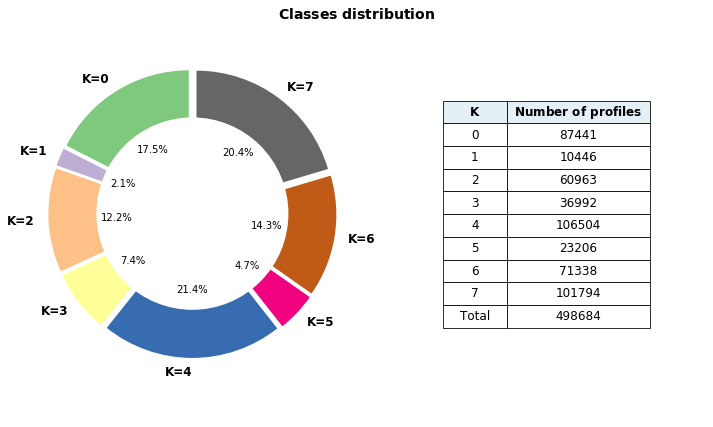

In [6]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')

In [ ]:
tablecn = [(1,2,3),(4,5,6)]
tablecn[:]

#### 5. Temporal representation 

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_bins = 'month')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_bins = 'season')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')

In [ ]:
#import xarray
#xarray.show_versions()

# Robustness

In [ ]:
P.plot_robustness(time_slice=7)
P.save_BlueCloud('figures/test_robustness.png')